# Diffuse 511 Spectral Fit in Galactic Coordinates

This notebook fits the spectrum for the 511 keV emission in the Galaxy. It can be used as a general template for fitting diffuse/extended sources in Galactic coordinates. For a general introduction into spectral fitting with cosipy, see the continuum_fit and line_fit tutorials.<br>

This notebook uses two 511 keV emission models, first a test model and then a realistic multi-component model. 

The test input model is available here: <br>
https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511/511_Testing <br>
It is a toy 511 model, consisting of two components: an extended Gaussian source (5 degree extension) and a point source. In the first part of this tutorial, we fit the data with just the single extended Gaussian component, i.e. we ignore the point source component. This is done as a simplification, and as will be seen, it already provides a good fit. In the second part of this tutorial we use a model consisting of both components. 

The realistic input models are available here: <br>https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511<br>
These are the realistic 511 models, consisting of a bulge component (with an extended Gaussian source and a point source) as well as a disk component with different spectral characteristics. In the third part of this tutorial we use this model. 

For the background we use just the cosmic photons. 

This tutotrial also walks through all the steps needed when performing a spectral fit, starting with the unbinned data, i.e. creating the combined data set, and binning the data. 

You will need the following files (available on wasabi):<br>
**20280301_3_month.ori <br>
cosmic_photons_3months_unbinned_data.fits.gz <br>
511_Testing_3months.fits.gz <br>
SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 <br>
psr_gal_511_DC2.h5** <br>

The binned data products are available on wasabi (directory below), so you can also start by loading the binned data directly: <br>
COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/

**WARNING:** If you run into memory issues creating the combined dataset or binning the data on your own, start by just loading the binned data directly. We are still working on optimizing the code, so please let us know if you run into these memory issues. <br>

In [1]:
# imports:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.response import PointSourceResponse
from cosipy.threeml.custom_functions import Wide_Asymm_Gaussian_on_sphere, SpecFromDat
from scoords import SpacecraftFrame
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astromodels import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from threeML import PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter
from astromodels import *
from mhealpy import HealpixMap, HealpixBase
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import os
import time
import h5py as h5
from histpy import Axis, Axes
import sys
from histpy import Histogram

Welcome to JupyROOT 6.28/10


20:59:17 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=227603;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=444712;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=991506;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=512314;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/home/field/COSItools_dev/python-env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


20:59:18 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=982021;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=278252;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

/home/field/COSItools_dev/python-env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


20:59:18 INFO      Starting 3ML!                                                                     ]8;id=167409;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=79375;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=923785;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=829159;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=540616;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=459623;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=600761;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=116054;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=463307;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=257978;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=232888;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=970266;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=847149;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=374853;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=804330;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=283125;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=645964;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=592196;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

20:59:19 WARNING   No fermitools installed                                              ]8;id=471852;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=424924;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

20:59:19 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=211360;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=354932;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=456929;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=627953;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=304331;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=449467;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Get the data
The data can be downloaded directly from wasabi, or you can copy them by running the cells below. Each respective cell also gives the path to the file, in case you are looking for the location on wasabi. 

In [ ]:
# ori file:
# wasabi path: COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori --endpoint-url=https://s3.us-west-1.wasabisys.com 20280301_3_month.ori")

In [ ]:
# cosmic photons:
# wasabi path: COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/cosmic_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com cosmic_photons_3months_unbinned_data.fits.gz")

In [ ]:
# 511 test model:
# wasabi path: COSI-SMEX/DC2/Data/Sources/511_Testing_3months.fits.gz 
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/511_Testing_3months.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com 511_Testing_3months.fits.gz")

In [ ]:
# detector response:
# wasabi path: COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5 --endpoint-url=https://s3.us-west-1.wasabisys.com SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5")

In [ ]:
# point source response:
# wasabi path: COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz
os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz --endpoint-url=https://s3.us-west-1.wasabisys.com psr_gal_511_DC2.h5.gz")
os.system("gzip -d psr_gal_511_DC2.h5.gz)

In [ ]:
# Binned data products:
# wasabi path: COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame 
file_list = ['cosmic_photons_binned_data.hdf5','gal_511_binned_data.hdf5','combined_binned_data.hdf5','combined_binned_data_thin_disk.hdf5']

for each in file_list:
    os.system("AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object  --bucket cosi-pipeline-public --key COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/%s --endpoint-url=https://s3.us-west-1.wasabisys.com %s" %(each,each))


## Create the combined data
We will combine the 511 source and the cosmic photon background, which will be used as our dataset. <br>
This only needs to be done once.<br>
You can skip this cell if you already have the combined data file.

In [ ]:
# Define instance of binned data class:
instance = BinnedData("Gal_511.yaml")

# Combine files:
input_files = ["cosmic_photons_3months_unbinned_data.fits.gz","511_Testing_3months_unbinned_data.fits.gz"]
instance.combine_unbinned_data(input_files, output_name="combined_data")

## Bin the data 
You only have to do this once, and after you can start by loading the binned data directly. <br>
You can skip this cell if you already have the binned data files.

In [ ]:
# Bin 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.get_binned_data(unbinned_data="511_Testing_3months_unbinned_data.fits.gz", output_name="gal_511_binned_data")

In [ ]:
# Bin background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.get_binned_data(unbinned_data="cosmic_photons_3months_unbinned_data.fits.gz", output_name="cosmic_photons_binned_data")

In [ ]:
# Bin combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.get_binned_data(unbinned_data="combined_data.fits.gz", output_name="combined_binned_data")

## Read in the binned data
Once you have the binned data files, you can start by loading them directly (instead of binning them each time).

In [ ]:
# Load 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.load_binned_data_from_hdf5(binned_data="gal_511_binned_data.hdf5")

# Load background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# Load combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.load_binned_data_from_hdf5(binned_data="combined_binned_data.hdf5")

## Define Source
The injected source has both an extended componenent and a point source component, <br>
but to start with we will ignore the point source component, <br>
and see how well we can describe the data with just the extended component. <br>
Define the extended source:

In [ ]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = True
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

Let's make some plots to look at the extended source:

In [ ]:
# Plot spectrum:
energy = np.linspace(500.,520.,201)*u.keV
dnde = src1.spectrum.main.Gaussian(energy)
plt.plot(energy, dnde)
plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14);

An extended source in astromodels corresponds to a skymap, which is normalized so that the sum over the entire sky, multiplied by the pixel area, equals 1. The pixel values in the skymap serve as weights, which we can use to scale the input spectrum, in order to get the model counts for any location on the sky. This is all handled internally within cosipy, but for demonstration purposes, let's take a look at the skymap:

In [ ]:
# Define healpix map matching the detector response:
skymap = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = skymap.pix2skycoord(range(skymap.npix))
pix_area = skymap.pixarea().value

# Fill skymap with values from extended source: 
skymap[:] = src1.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg) 

# Check normalization:
print("summed map: " + str(np.sum(skymap)*pix_area))

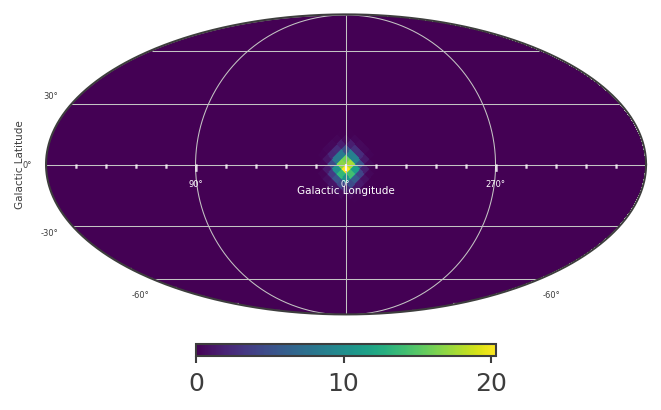

In [6]:
# Plot healpix map:
plot, ax = skymap.plot(ax_kw = {'coord':'G'})
ax.grid()
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
lat.set_axislabel('Galactic Latitude',fontsize=5)
lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
lon.set_ticks_visible(True)
lon.set_ticklabel_visible(True)
lon.set_ticks(color='white',alpha=0.6)
lat.set_ticks(color='white',alpha=0.6)
lon.set_ticklabel(color='white',fontsize=4)
lat.set_ticklabel(fontsize=4)
lat.set_ticks_visible(True)
lat.set_ticklabel_visible(True)

(1e-50, 1)

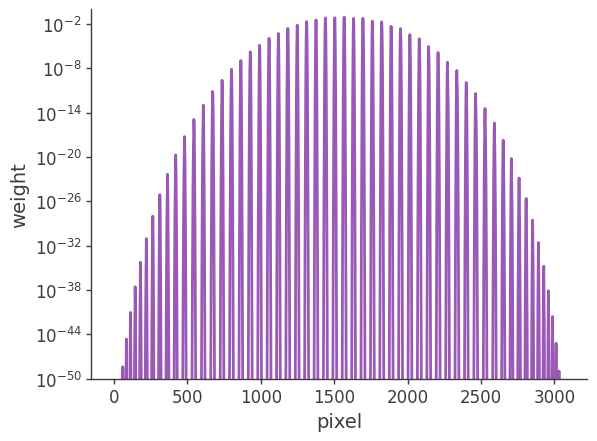

In [7]:
# Plot weights directly
# Note: for extended sources the weights also need to include the pixel area.
plt.semilogy(skymap[:]*pix_area)
plt.ylabel("weight")
plt.xlabel("pixel")
plt.ylim(1e-50,1);

## Setup the COSI 3ML plugin and Perform the Likelihood Fit
Load the detector response, ori file, and precomputed point source response in Galactic coordinates:

In [8]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

Setup the COSI 3ML plugin:

In [9]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

... loading the pre-computed image response ...
--> done


Perform likelihood fit: 

In [12]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

10:06:34 INFO      set the minimizer to minuit                                             ]8;id=617946;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=502315;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\


WARNING RuntimeWarning: invalid value encountered in log



10:09:41 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=280057;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=523319;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.695 +/- 0.033) x 10^-2,1 / (s cm2)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.005) x 10^2,keV
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,1.00,-0.01
1.00,1.00,0.02
-0.01,0.02,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


(                                         value  negative_error  \
 gaussian.spectrum.main.Gaussian.F     0.046951       -0.000332   
 gaussian.spectrum.main.Gaussian.mu  510.999885       -0.459983   
 background_cosi                       0.932127       -0.004774   
 
                                     positive_error     error         unit  
 gaussian.spectrum.main.Gaussian.F         0.000333  0.000332  1 / (s cm2)  
 gaussian.spectrum.main.Gaussian.mu        0.465312  0.462648          keV  
 background_cosi                           0.004723  0.004749               ,
        -log(likelihood)
 cosi      -1.527559e+07
 total     -1.527559e+07)

## Results
First, let's just print the results. <br>

In [13]:
results = like.results
results.display()

# Print a summary of the optimized model:
print(results.optimized_model["gaussian"])

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.695 +/- 0.033) x 10^-2,1 / (s cm2)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.005) x 10^2,keV
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,1.00,-0.01
1.00,1.00,0.02
-0.01,0.02,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


  * gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.046951067636512224
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
       

Now let's make some plots. <br>
Let's first look at the best-fit spectrum:

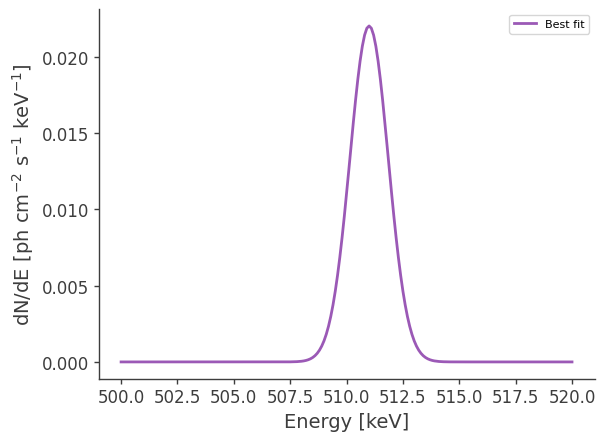

In [14]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
flux = results.optimized_model["gaussian"].spectrum.main.shape(energy)

fig,ax = plt.subplots()

ax.plot(energy, flux, label = "Best fit")


plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)
ax.legend()

Now let's compare the predicted counts to the injected counts:

Error: [2129.0618147]


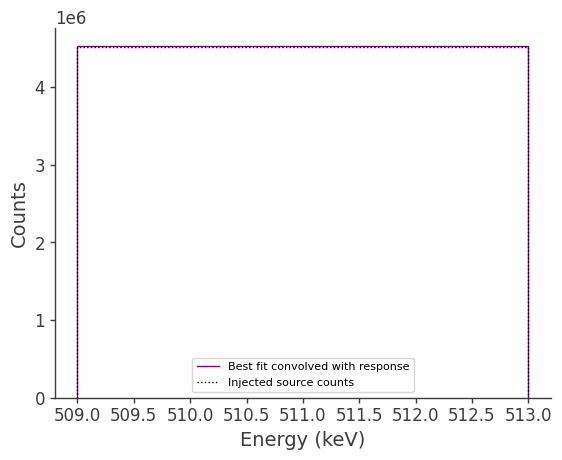

In [15]:
# Get expected counts from likelihood scan (i.e. best-fit convolved with response):
total_expectation = cosi._expected_counts['gaussian']

# Plot:       
fig,ax = plt.subplots()

binned_energy_edges = gal_511.binned_data.axes['Em'].edges.value
binned_energy = gal_511.binned_data.axes['Em'].centers.value

ax.stairs(total_expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, total_expectation.project('Em').todense().contents, yerr=np.sqrt(total_expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(gal_511.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Injected source counts")
ax.errorbar(binned_energy, gal_511.binned_data.project('Em').todense().contents, yerr=np.sqrt(gal_511.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

# Note: We are plotting the error, but it's very small:
print("Error: " +str(np.sqrt(total_expectation.project('Em').todense().contents)))

Let's also compare the projection onto Psichi:

Text(0.5, 1.0, 'injected counts')

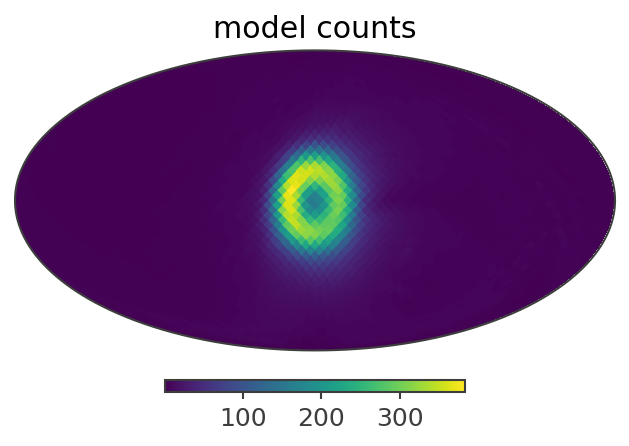

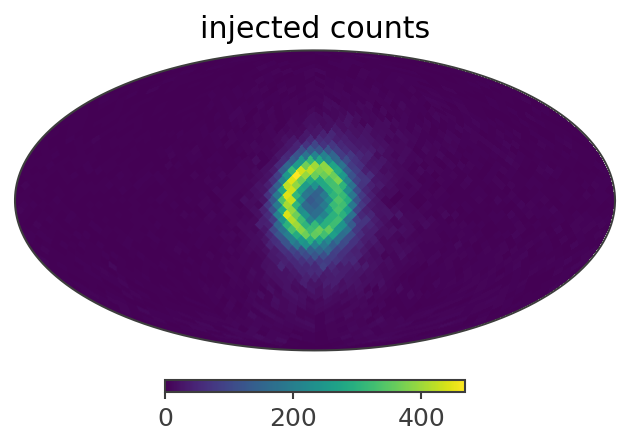

In [16]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

Here is a summary of the results:

Injected model (extended source): <br>
F = 4e-2 ph/cm2/s <br>
mu = 511 keV <br>

Best-fit: <br>
F = (4.695 +/- 0.033)e-2 ph/cm2/s <br>
mu = 511.0 +/- 0.5 keV <br>

We see that the best-fit values are very close to the injected values. The small difference is likely due to the fact that the injected model also has a point source component (which we've ignored), having the same specrtum, with a normalization of F = 1e-2 ph/cm2/s. In the next example we'll see if this point source component can be detected. 

# **********************************************************
## Perform Analysis with Two Components

Define the point source. <br>
We'll add this to the model, and keep just the normalization free.

In [17]:
# Note: Astromodels only takes ra,dec for point source input:
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')

# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 1e-2 / u.cm / u.cm / u.s  
Fmin = 0 / u.cm / u.cm / u.s
Fmax = 1 / u.cm / u.cm / u.s
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum2 = Gaussian()
spectrum2.F.value = F.value
spectrum2.F.unit = F.unit
spectrum2.F.min_value = Fmin.value
spectrum2.F.max_value = Fmax.value
spectrum2.mu.value = mu.value
spectrum2.mu.unit = mu.unit
spectrum2.sigma.value = sigma.value
spectrum2.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum2.F.free = True
spectrum2.mu.free = False
spectrum2.sigma.free = False

# Define source:
src2 = PointSource('point_source', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=spectrum2)

# Print some info about the source just as a sanity check.
# This will also show you which parameters are free. 
print(src2.spectrum.main.shape)

# We can also get a summary of the source info as follows:
#src2.display()

  * description: A Gaussian function
  * formula: $ K \frac{1}{\sigma \sqrt{2 \pi}}\exp{\frac{(x-\mu)^2}{2~(\sigma)^2}} $
  * parameters:
    * F:
      * value: 0.01
      * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
      * min_value: 0.0
      * max_value: 1.0
      * unit: s-1 cm-2
      * is_normalization: false
      * delta: 0.1
      * free: true
    * mu:
      * value: 511.0
      * desc: Central value
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false
    * sigma:
      * value: 0.85
      * desc: standard deviation
      * min_value: 1.0e-12
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false



Redefine the first source.<br> 
We'll keep just the normalization free. 

In [18]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s 
Fmin = 0 / u.cm / u.cm / u.s
Fmax = 1 / u.cm / u.cm / u.s
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.F.min_value = Fmin.value
spectrum.F.max_value = Fmax.value
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = False
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print a summary of the source info:
src1.display()

# We can also print the source info as follows.
# This will also show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: 0.0
            * max_value: 1.0
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

Setup the COSI 3ML plugin using two sources in the model:

In [19]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
                 
# Add sources to model:
model = Model(src1, src2)  # Model with two sources.

... loading the pre-computed image response ...
--> done


Display the model:

In [21]:
model.display()

Model summary:
==============

                  N
Point sources     1
Extended sources  1
Particle sources  0

Free parameters (2):
--------------------

                                      value min_value max_value      unit
gaussian.spectrum.main.Gaussian.F      0.04       0.0       1.0  s-1 cm-2
point_source.spectrum.main.Gaussian.F  0.01       0.0       1.0  s-1 cm-2

Fixed parameters (9):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Perform the likelihood fit:

In [22]:
start = time.time()

plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = True)

like.fit()

stop = time.time()
total_time = stop - start
print("processing time [min]: " + str(total_time/60.0))

... Calculating point source responses ...
--> done (source name : point_source)
--> all done


10:23:37 INFO      set the minimizer to minuit                                             ]8;id=474358;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=691555;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

10:23:38 INFO      trial values: 0.04,0.01,1 -> logL = 14908358.728                        ]8;id=529993;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250526;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:40 INFO      trial values: 0.040804,0.01,1 -> logL = 14911295.359                    ]8;id=669379;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=752683;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:41 INFO      trial values: 0.039204,0.01,1 -> logL = 14904015.715                    ]8;id=566639;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=220839;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:42 INFO      trial values: 0.04008,0.01,1 -> logL = 14908715.495                     ]8;id=169717;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=885837;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:43 INFO      trial values: 0.03992,0.01,1 -> logL = 14907987.897                     ]8;id=770881;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708212;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:44 INFO      trial values: 0.04,0.010201,1 -> logL = 14898734.111                    ]8;id=5216;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=429921;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:46 INFO      trial values: 0.04,0.009801,1 -> logL = 14917820.671                    ]8;id=29666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506096;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:47 INFO      trial values: 0.04,0.010042,1 -> logL = 14906360.208                    ]8;id=3743;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=335984;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:48 INFO      trial values: 0.04,0.0099582,1 -> logL = 14910350.138                   ]8;id=263193;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195428;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:49 INFO      trial values: 0.04,0.01,1.0201 -> logL = 14907769.198                   ]8;id=766667;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=988591;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:51 INFO      trial values: 0.04,0.01,0.98007 -> logL = 14908928.814                  ]8;id=685760;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=751116;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:52 INFO      trial values: 0.04,0.01,1.0121 -> logL = 14908004.588                   ]8;id=197378;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877932;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:53 INFO      trial values: 0.04,0.01,0.98793 -> logL = 14908705.758                  ]8;id=648700;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167608;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:54 INFO      trial values: 0.042095,0.0016969,0.47859 -> logL = 15226326.006         ]8;id=843451;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=31265;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:55 INFO      trial values: 0.04229,0.0012799,0.43902 -> logL = 15232794.823          ]8;id=539888;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=74316;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:57 INFO      trial values: 0.042523,0.000861,0.39406 -> logL = 15237090.316          ]8;id=83550;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=580976;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:58 INFO      trial values: 0.042678,0.00062687,0.36521 -> logL = 15238270.567        ]8;id=209306;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=28187;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:23:59 INFO      trial values: 0.042738,0.00062687,0.36521 -> logL = 15238920.893        ]8;id=904550;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175292;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:00 INFO      trial values: 0.042619,0.00062687,0.36521 -> logL = 15237612.079        ]8;id=801968;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=658462;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:01 INFO      trial values: 0.042678,0.00063755,0.36521 -> logL = 15238251.031        ]8;id=417889;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95691;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:03 INFO      trial values: 0.042678,0.00061628,0.36521 -> logL = 15238287.734        ]8;id=233945;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=239163;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:04 INFO      trial values: 0.042678,0.00064563,0.36521 -> logL = 15238234.771        ]8;id=669391;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129968;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:05 INFO      trial values: 0.042678,0.00060838,0.36521 -> logL = 15238299.096        ]8;id=137372;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=27726;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:06 INFO      trial values: 0.042678,0.00062687,0.3732 -> logL = 15238686.158         ]8;id=3665;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=546117;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:08 INFO      trial values: 0.042678,0.00062687,0.3573 -> logL = 15237853.117         ]8;id=291484;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=953932;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:09 INFO      trial values: 0.042678,0.00062687,0.3811 -> logL = 15239090.507         ]8;id=780847;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773498;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:10 INFO      trial values: 0.042678,0.00062687,0.34964 -> logL = 15237443.362        ]8;id=363846;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=530272;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:11 INFO      trial values: 0.048599,0.0002466,0.8657 -> logL = 15271663.872          ]8;id=728253;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65341;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:12 INFO      trial values: 0.047517,0.00030163,0.76339 -> logL = 15273594.939        ]8;id=234580;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318447;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:14 INFO      trial values: 0.047576,0.00030163,0.76339 -> logL = 15273537.994        ]8;id=110082;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=433930;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:15 INFO      trial values: 0.047458,0.00030163,0.76339 -> logL = 15273645.122        ]8;id=249123;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=307217;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:16 INFO      trial values: 0.047517,0.0003147,0.76339 -> logL = 15273484.793         ]8;id=602245;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894040;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:17 INFO      trial values: 0.047517,0.00028883,0.76339 -> logL = 15273699.130        ]8;id=972989;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=856754;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:18 INFO      trial values: 0.047517,0.00030163,0.78528 -> logL = 15273652.336        ]8;id=779324;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=94833;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:20 INFO      trial values: 0.047517,0.00030163,0.74174 -> logL = 15273511.259        ]8;id=821654;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=167296;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:21 INFO      trial values: 0.047517,0.00030163,0.77488 -> logL = 15273628.459        ]8;id=358842;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=221202;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:22 INFO      trial values: 0.047517,0.00030163,0.75196 -> logL = 15273554.136        ]8;id=574628;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=90933;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:23 INFO      trial values: 0.047263,0.00023218,0.83736 -> logL = 15274478.508        ]8;id=9666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256680;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:25 INFO      trial values: 0.046818,0.00013202,0.97403 -> logL = 15275112.491        ]8;id=678518;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582757;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:26 INFO      trial values: 0.046879,0.00013202,0.97403 -> logL = 15275100.573        ]8;id=798598;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12255;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:27 INFO      trial values: 0.046758,0.00013202,0.97403 -> logL = 15275117.124        ]8;id=528696;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748558;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:28 INFO      trial values: 0.046818,0.00014165,0.97403 -> logL = 15275059.149        ]8;id=466636;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=477365;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:29 INFO      trial values: 0.046818,0.00012272,0.97403 -> logL = 15275161.495        ]8;id=485362;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=280640;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:31 INFO      trial values: 0.046818,0.00013202,0.98668 -> logL = 15275066.922        ]8;id=719114;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=307187;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:32 INFO      trial values: 0.046818,0.00013202,0.96144 -> logL = 15275149.774        ]8;id=419286;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=554834;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:33 INFO      trial values: 0.046781,9.8025e-05,0.94402 -> logL = 15275339.943        ]8;id=197097;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=726675;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:34 INFO      trial values: 0.046742,6.8231e-05,0.91341 -> logL = 15275432.185        ]8;id=962611;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=531925;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:35 INFO      trial values: 0.046737,6.4575e-05,0.90926 -> logL = 15275434.623        ]8;id=893926;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=369521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:37 INFO      trial values: 0.046797,6.4575e-05,0.90926 -> logL = 15275455.595        ]8;id=34630;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=596563;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:38 INFO      trial values: 0.046676,6.4575e-05,0.90926 -> logL = 15275406.324        ]8;id=888064;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=54438;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:39 INFO      trial values: 0.046737,7.3438e-05,0.90926 -> logL = 15275412.007        ]8;id=412631;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413152;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:40 INFO      trial values: 0.046737,5.6281e-05,0.90926 -> logL = 15275453.370        ]8;id=619629;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=560870;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:41 INFO      trial values: 0.046737,6.4575e-05,0.92081 -> logL = 15275445.583        ]8;id=917580;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:43 INFO      trial values: 0.046737,6.4575e-05,0.89777 -> logL = 15275416.592        ]8;id=199220;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=621867;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:44 INFO      trial values: 0.046895,3.706e-05,0.92235 -> logL = 15275542.470         ]8;id=545577;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=536651;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:45 INFO      trial values: 0.046993,2.3897e-05,0.93044 -> logL = 15275563.633        ]8;id=632898;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:46 INFO      trial values: 0.047054,2.3897e-05,0.93044 -> logL = 15275552.836        ]8;id=608934;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=109202;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:47 INFO      trial values: 0.046932,2.3897e-05,0.93044 -> logL = 15275567.167        ]8;id=471731;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=792264;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:49 INFO      trial values: 0.046993,3.1596e-05,0.93044 -> logL = 15275549.674        ]8;id=923580;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=556524;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:50 INFO      trial values: 0.046993,1.7272e-05,0.93044 -> logL = 15275573.841        ]8;id=984773;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454143;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:51 INFO      trial values: 0.046993,2.3897e-05,0.94227 -> logL = 15275555.189        ]8;id=216789;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=549220;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:52 INFO      trial values: 0.046993,2.3897e-05,0.91866 -> logL = 15275564.690        ]8;id=166199;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=557129;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:53 INFO      trial values: 0.046971,1.4613e-05,0.93088 -> logL = 15275579.115        ]8;id=834506;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858169;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:55 INFO      trial values: 0.046944,6.3454e-06,0.93143 -> logL = 15275588.809        ]8;id=679262;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=915653;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:56 INFO      trial values: 0.046932,3.7175e-06,0.93168 -> logL = 15275590.799        ]8;id=93491;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=336521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:57 INFO      trial values: 0.046922,2.0723e-06,0.93188 -> logL = 15275591.595        ]8;id=183718;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=546902;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:58 INFO      trial values: 0.046917,1.3878e-06,0.93199 -> logL = 15275591.752        ]8;id=200071;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=983223;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:24:59 INFO      trial values: 0.046978,1.3878e-06,0.93199 -> logL = 15275592.075        ]8;id=4492;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=350219;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:01 INFO      trial values: 0.046856,1.3878e-06,0.93199 -> logL = 15275584.135        ]8;id=334552;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=998157;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:02 INFO      trial values: 0.046917,4.8349e-06,0.93199 -> logL = 15275589.240        ]8;id=280970;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=337635;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:03 INFO      trial values: 0.046917,2.4735e-08,0.93199 -> logL = 15275592.608        ]8;id=497330;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=856089;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:04 INFO      trial values: 0.046917,1.102e-05,0.93199 -> logL = 15275583.513         ]8;id=73552;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=684110;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:05 INFO      trial values: 0.046917,9.2826e-07,0.93199 -> logL = 15275592.049        ]8;id=149065;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18355;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:06 INFO      trial values: 0.046917,1.3878e-06,0.94375 -> logL = 15275589.607        ]8;id=143018;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58911;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:08 INFO      trial values: 0.046917,1.3878e-06,0.9203 -> logL = 15275586.601         ]8;id=297500;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=422114;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:09 INFO      trial values: 0.046947,3.4605e-07,0.93288 -> logL = 15275593.536        ]8;id=6034;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:10 INFO      trial values: 0.04695,2.6921e-07,0.93298 -> logL = 15275593.589         ]8;id=93345;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=729360;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:11 INFO      trial values: 0.046954,1.9481e-07,0.9331 -> logL = 15275593.609         ]8;id=602812;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=963519;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:12 INFO      trial values: 0.047015,1.9481e-07,0.9331 -> logL = 15275589.344         ]8;id=617409;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=87456;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:14 INFO      trial values: 0.046893,1.9481e-07,0.9331 -> logL = 15275590.593         ]8;id=900475;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=849626;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:15 INFO      trial values: 0.046954,6.212e-06,0.9331 -> logL = 15275588.711          ]8;id=518022;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809713;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:16 INFO      trial values: 0.046954,2.591e-06,0.9331 -> logL = 15275591.838          ]8;id=30775;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=483871;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:17 INFO      trial values: 0.046954,1.9481e-07,0.94485 -> logL = 15275589.178        ]8;id=462727;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195962;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:18 INFO      trial values: 0.046954,1.9481e-07,0.9214 -> logL = 15275590.750         ]8;id=95036;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485967;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:20 INFO      trial values: 0.046954,4.4797e-08,0.93239 -> logL = 15275593.748        ]8;id=737433;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=672241;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:21 INFO      trial values: 0.046953,2.1913e-08,0.9322 -> logL = 15275593.767         ]8;id=458122;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17620;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:22 INFO      trial values: 0.046953,4.8239e-10,0.93181 -> logL = 15275593.784        ]8;id=287186;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259947;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:23 INFO      trial values: 0.047014,4.8239e-10,0.93181 -> logL = 15275589.973        ]8;id=199507;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=748149;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:24 INFO      trial values: 0.046892,4.8239e-10,0.93181 -> logL = 15275590.310        ]8;id=348871;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250362;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:26 INFO      trial values: 0.046953,4.6896e-06,0.93181 -> logL = 15275590.223        ]8;id=391704;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=196009;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:27 INFO      trial values: 0.046953,4.5013e-06,0.93181 -> logL = 15275590.383        ]8;id=468669;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372370;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:28 INFO      trial values: 0.046953,4.8239e-10,0.94355 -> logL = 15275590.235        ]8;id=283017;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=356230;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:29 INFO      trial values: 0.046953,4.8239e-10,0.92013 -> logL = 15275590.053        ]8;id=872234;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=503219;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:30 INFO      trial values: 0.046951,1.2946e-12,0.93209 -> logL = 15275593.788        ]8;id=428977;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=804395;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:31 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=45836;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=176393;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:33 INFO      trial values: 0.047012,1.3798e-12,0.93212 -> logL = 15275590.152        ]8;id=866621;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=492978;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:34 INFO      trial values: 0.04689,1.3798e-12,0.93212 -> logL = 15275590.141         ]8;id=740729;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=131063;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:35 INFO      trial values: 0.046951,4.803e-06,0.93212 -> logL = 15275590.128         ]8;id=844270;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=673256;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:36 INFO      trial values: 0.046951,4.8133e-06,0.93212 -> logL = 15275590.119        ]8;id=620471;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=877945;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:37 INFO      trial values: 0.046951,1.3798e-12,0.94387 -> logL = 15275590.145        ]8;id=24306;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714515;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:39 INFO      trial values: 0.046951,1.3798e-12,0.92043 -> logL = 15275590.147        ]8;id=807165;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=652731;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:40 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=514984;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=719753;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:41 INFO      trial values: 0.047012,1.3798e-12,0.93212 -> logL = 15275590.152        ]8;id=342760;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=982169;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:42 INFO      trial values: 0.04689,1.3798e-12,0.93212 -> logL = 15275590.141         ]8;id=263119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=284728;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:44 INFO      trial values: 0.046951,4.803e-06,0.93212 -> logL = 15275590.128         ]8;id=148967;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=174490;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:45 INFO      trial values: 0.046951,4.8133e-06,0.93212 -> logL = 15275590.119        ]8;id=995668;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=177200;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:46 INFO      trial values: 0.046951,1.3798e-12,0.94387 -> logL = 15275590.145        ]8;id=799055;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=328216;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:47 INFO      trial values: 0.046951,1.3798e-12,0.92043 -> logL = 15275590.147        ]8;id=930661;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=338893;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:49 INFO      trial values: 0.046963,1.3798e-12,0.93212 -> logL = 15275593.644        ]8;id=951760;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468946;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:50 INFO      trial values: 0.046939,1.3798e-12,0.93212 -> logL = 15275593.642        ]8;id=130374;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=209371;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:51 INFO      trial values: 0.046953,1.3798e-12,0.93212 -> logL = 15275593.783        ]8;id=911151;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=136823;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:52 INFO      trial values: 0.046949,1.3798e-12,0.93212 -> logL = 15275593.782        ]8;id=469008;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994901;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:53 INFO      trial values: 0.046951,1.913e-07,0.93212 -> logL = 15275593.661         ]8;id=751424;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=343887;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:55 INFO      trial values: 0.046951,1.9336e-07,0.93212 -> logL = 15275593.659        ]8;id=35672;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=810835;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:56 INFO      trial values: 0.046951,7.4883e-09,0.93212 -> logL = 15275593.783        ]8;id=358970;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=210794;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:57 INFO      trial values: 0.046951,7.9005e-09,0.93212 -> logL = 15275593.783        ]8;id=212165;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=12075;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:25:58 INFO      trial values: 0.046951,1.3798e-12,0.93447 -> logL = 15275593.644        ]8;id=463039;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17523;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:00 INFO      trial values: 0.046951,1.3798e-12,0.92978 -> logL = 15275593.641        ]8;id=229852;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=426005;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:01 INFO      trial values: 0.046951,1.3798e-12,0.93259 -> logL = 15275593.783        ]8;id=381856;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779656;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:02 INFO      trial values: 0.046951,1.3798e-12,0.93165 -> logL = 15275593.782        ]8;id=731688;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=514407;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:03 INFO      trial values: 0.047012,4.803e-06,0.93212 -> logL = 15275585.967         ]8;id=376412;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223544;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:05 INFO      trial values: 0.047012,1.3798e-12,0.94387 -> logL = 15275583.576        ]8;id=370954;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=989251;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:06 INFO      trial values: 0.046951,4.803e-06,0.94387 -> logL = 15275585.723         ]8;id=764885;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=488119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:07 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=10416;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=206057;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:08 INFO      trial values: 0.046953,1.3798e-12,0.93212 -> logL = 15275593.783        ]8;id=710414;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320110;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:09 INFO      trial values: 0.046949,1.3798e-12,0.93212 -> logL = 15275593.782        ]8;id=74703;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=652866;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:11 INFO      trial values: 0.046951,7.4883e-09,0.93212 -> logL = 15275593.783        ]8;id=919276;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=144188;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:12 INFO      trial values: 0.046951,7.9005e-09,0.93212 -> logL = 15275593.783        ]8;id=274337;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=126859;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:13 INFO      trial values: 0.046951,7.6724e-07,0.93212 -> logL = 15275593.268        ]8;id=752080;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427877;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:14 INFO      trial values: 0.046951,7.7136e-07,0.93212 -> logL = 15275593.265        ]8;id=274309;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=657141;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:16 INFO      trial values: 0.046951,1.3798e-12,0.93259 -> logL = 15275593.783        ]8;id=669260;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342991;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:17 INFO      trial values: 0.046951,1.3798e-12,0.93165 -> logL = 15275593.782        ]8;id=555641;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=131675;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:18 INFO      trial values: 0.046952,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=802629;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=158342;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:19 INFO      trial values: 0.046951,1.3798e-12,0.93212 -> logL = 15275593.788        ]8;id=371120;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671004;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:21 INFO      trial values: 0.046951,3.0361e-08,0.93212 -> logL = 15275593.768        ]8;id=193149;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=708907;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:22 INFO      trial values: 0.046951,3.1186e-08,0.93212 -> logL = 15275593.768        ]8;id=299285;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=838252;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:23 INFO      trial values: 0.046951,1.3798e-12,0.93221 -> logL = 15275593.788        ]8;id=754158;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858656;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:24 INFO      trial values: 0.046951,1.3798e-12,0.93203 -> logL = 15275593.788        ]8;id=726793;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=893764;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:26 INFO      trial values: 0.046953,7.6724e-07,0.93212 -> logL = 15275593.259        ]8;id=528666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204668;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:27 INFO      trial values: 0.046953,1.3798e-12,0.93259 -> logL = 15275593.772        ]8;id=201703;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=716735;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:28 INFO      trial values: 0.046951,7.6724e-07,0.93259 -> logL = 15275593.257        ]8;id=247529;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=293536;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

10:26:29 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=119279;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=106548;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   50.36000000000001 percent of samples have been thrown away because they ]8;id=321611;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=72652;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(4.6951 +/- 0.0025) x 10^-2,1 / (s cm2)
point_source.spectrum.main.Gaussian.F,(0.0 +/- 2.0) x 10^-9,1 / (s cm2)
background_cosi,(9.32 +/- 0.05) x 10^-1,


Correlation matrix:

1.00,0.01,-0.40
0.01,1.00,0.04
-0.40,0.04,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-1.527559e+07
total,-1.527559e+07


Values of statistical measures:

,statistical measures
AIC,-3.055119e+07
BIC,-3.055119e+07


processing time [min]: 6.2028670390446985


We see that the normalization of the point source has gone to zero, and we essentially get the same results as the first fit. This is not entirely surprising, considering that the two components have a high degree of degeneracy, and the point source is subdominant. 

Note (CK): The injected model may not be exactly the same as the astromodel, because MEGAlib uses a cutoff of the Gaussian spectral distribution at 3 sigma. I will update this in the near future for better consistency. I am also considering using an even simpler model, consisting of just the extended source.  

# Example 3: working with a realistic Model

## Read in the binned data
We will start with the binned data, since we already learned how to bin data: 

In [2]:
# background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# combined data:
data_combined_thin_disk = BinnedData("Gal_511.yaml")
data_combined_thin_disk.load_binned_data_from_hdf5(binned_data="combined_binned_data_thin_disk.hdf5")

## Define Source
This defines a multi-component source with a disk and gaussian component. The disk and bulge components have different spectral characteristics. Spatially, the bulge component is the sum of three different spatial models, with majority of the flux  "narrow bulge" with 

In [9]:
# Spectral Definitions...

models = ["centralPoint","narrowBulge","broadBulge","disk"]

# several lists of parameters for, in order, CentralPoint, NarrowBulge, BroadBulge, and Disk sources
mu         = [511.,511.,511., 511.]*u.keV
sigma      = [2./2.335,2./2.335,2./2.335, 3./2.335]*u.keV
F          = [0.00012, 0.00028, 0.00073, 1.7e-3]/u.cm/u.cm/u.s
K          = [0.00046, 0.0011, 0.0027, 4.5e-3]/u.cm/u.cm/u.s/u.keV

SpecLine   = [Gaussian(),Gaussian(),Gaussian(),Gaussian()]
SpecOPs    = [SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat")]

# Set units and fitting parameters; different definition for each spectral model with different norms
for i in range(4):
    SpecLine[i].F.unit = F[i].unit
    SpecLine[i].F.value = F[i].value
    SpecLine[i].F.min_value =0
    SpecLine[i].F.max_value=1
    SpecLine[i].mu.value = mu[i].value
    SpecLine[i].mu.unit = mu[i].unit
    SpecLine[i].sigma.unit = sigma[i].unit
    SpecLine[i].sigma.value = sigma[i].value

    SpecOPs[i].K.value = K[i].value
    SpecOPs[i].K.unit = K[i].unit
    
    SpecLine[i].sigma.free = False
    SpecLine[i].mu.free = False
    SpecLine[i].F.free = True
    SpecOPs[i].K.free = False # not fitting the amplitude of the OPs component for now, since we are only using the 511 response! 

# Generate Composite Spectra
SpecCentralPoint= SpecLine[0] + SpecOPs[0]
SpecNarrowBulge = SpecLine[1] + SpecOPs[1]
SpecBroadBulge  = SpecLine[2] + SpecOPs[2]
SpecDisk        = SpecLine[3] + SpecOPs[3]

In [10]:
# Define Spatial Model Components
MapNarrowBulge = Gaussian_on_sphere(lon0 = 0, lat0 = 0, sigma = 2.5)
MapBroadBulge = Gaussian_on_sphere(lon0 = 0, lat0 = 0, sigma = 8.7)
MapDisk = Wide_Asymm_Gaussian_on_sphere(lon0 = 0, lat0 = 0, a=90, e = 0.99944429,theta=0)

# Fix fitting parameters (same for all models)
for map in [MapNarrowBulge,MapBroadBulge]:
    map.lon0.free=False
    map.lat0.free=False
    map.sigma.free=False
    
MapDisk.lon0.free=False
MapDisk.lat0.free=False
MapDisk.a.free=False
MapDisk.e.free=False
MapDisk.theta.free=False

For the Wide_Asymm_Gaussian_on_sphere model, note that e is the eccentricity of the Gaussian ellipse, defined such that the scale height b of the disk is given by $b = a \sqrt{(1-e^2)}$

In [11]:
# Define Spatio-spectral models

# Bulge
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')
ModelCentralPoint = PointSource('centralPoint', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=SpecCentralPoint)
ModelNarrowBulge = ExtendedSource('narrowBulge',spectral_shape=SpecNarrowBulge,spatial_shape=MapNarrowBulge)
ModelBroadBulge = ExtendedSource('broadBulge',spectral_shape=SpecBroadBulge,spatial_shape=MapBroadBulge)

# Disk
ModelDisk = ExtendedSource('disk',spectral_shape=SpecDisk,spatial_shape=MapDisk)

In [12]:
ModelDisk

* disk (extended source):
    * shape:
      * lon0:
        * value: 0.0
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: 0.0
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * a:
        * value: 90.0
        * desc: Standard deviation of the Gaussian distribution (major axis)
        * min_value: 0.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * e:
        * value: 0.99944429
        * desc: Excentricity of Gaussian ellipse, e^2 = 1 - (b/a)^2, where b is the standard
          * deviation of the Gaussian distribution (minor axis)
        * min_value: 0.0
        * max_value: 1.0
        * unit: ''
        * is_normalization: false
      * theta:
        * value: 0.0
        * desc: inclination of major axis to a line of constant latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * composite:
          * F_1:
            * value: 0.0017
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: 0.0
            * max_value: 1.0
            * unit: s-1 cm-2
            * is_normalization: false
          * mu_1:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma_1:
            * value: 1.284796573875803
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
          * K_2:
            * value: 0.004499999999999998
            * desc: Normalization
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * dat_2:
            * value: OPsSpectrum.dat
        * polarization: {}

Make some plots to look at these new extended sources:

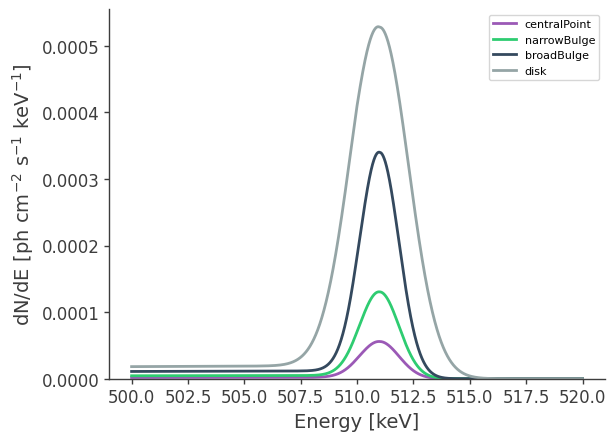

In [13]:
# Plot spectra at 511 keV
energy = np.linspace(500.,520.,10001)*u.keV
fig, axs = plt.subplots()
for label,m in zip(models,
                   [ModelCentralPoint,ModelNarrowBulge,ModelBroadBulge,ModelDisk]):
    dnde = m.spectrum.main.composite(energy)
    axs.plot(energy, dnde,label=label)

axs.legend()
axs.set_ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
axs.set_xlabel("Energy [keV]", fontsize=14);
plt.ylim(0,);
#axs[0].set_yscale("log")

The orthopositronium spectral component appears as the low-energy tail of the 511 keV line.

In [14]:
# Define healpix map matching the detector response:
nside_model = 2**4
scheme='ring'
is_nested = (scheme == 'nested')
coordsys='G'

mBroadBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mNarrowBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mPointBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mDisk = HealpixMap(nside = nside_model, scheme=scheme, dtype = float,coordsys=coordsys)

coords = mDisk.pix2skycoord(range(mDisk.npix)) # common among all the galactic maps...

pix_area = mBroadBulge.pixarea().value # common among all the galactic maps with the same pixelization

# Fill skymap with values from extended source: 
mNarrowBulge[:] = ModelNarrowBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBroadBulge[:] = ModelBroadBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBulge = mBroadBulge + mNarrowBulge
mDisk[:] = ModelDisk.spatial_shape(coords.l.deg, coords.b.deg)

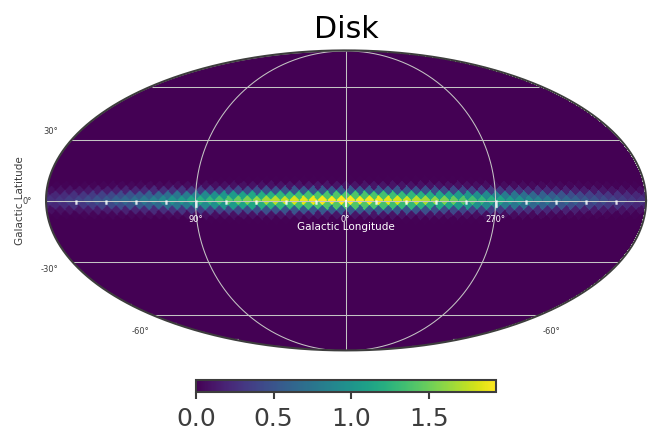

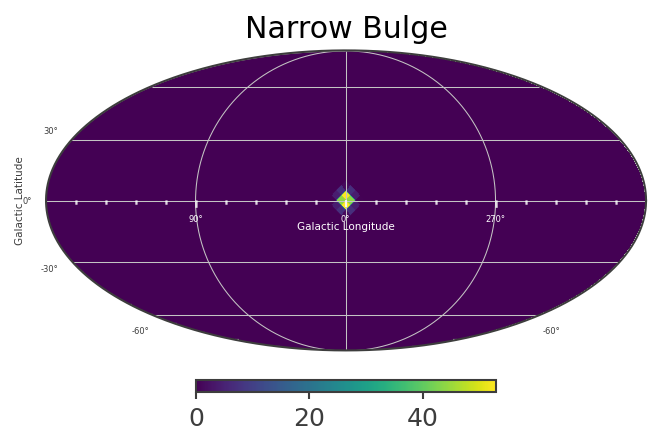

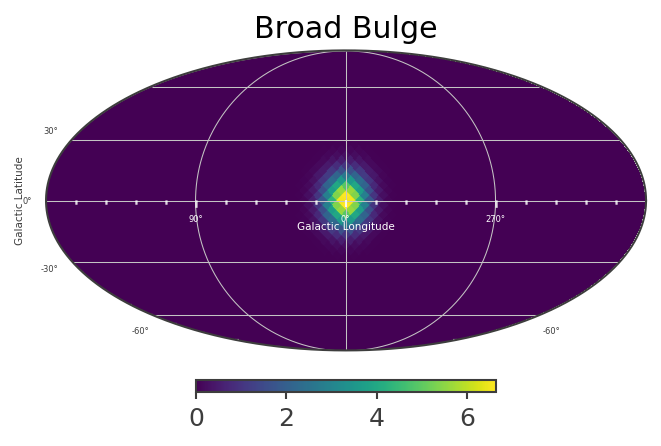

In [15]:
List_of_Maps = [mDisk,mNarrowBulge,mBroadBulge]
List_of_Names = ["Disk","Narrow Bulge","Broad Bulge", ]

for n, m in zip(List_of_Names,List_of_Maps):
    plot,ax = m.plot(ax_kw={"coord":"G"})
    ax.grid();
    lon = ax.coords['glon']
    lat = ax.coords['glat']
    lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
    lat.set_axislabel('Galactic Latitude',fontsize=5)
    lon.display_minor_ticks(True)
    lat.display_minor_ticks(True)
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lon.set_ticks(color='white',alpha=0.6)
    lat.set_ticks(color='white',alpha=0.6)
    lon.set_ticklabel(color='white',fontsize=4)
    lat.set_ticklabel(fontsize=4)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    ax.set_title(n)

## Instantiate the COSI 3ML plugin and perform the Likelihood Fit
The following two cells should be run only if not already run in previous examples...

In [16]:
# if not previously loaded in example 1, load the response, ori, and psr: 
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")
psr_file = "psr_gal_511_DC2.h5"

In [17]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

In [18]:
# Instantiate the COSI 3ML plugin, using combined data for the thin disk
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined_thin_disk.binned_data.project('Em', 'Phi', 'PsiChi'),# data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),       # background model 
                sc_orientation = ori,                                          # spacecraft orientation
                nuisance_param = bkg_par,                                      # background parameter
                precomputed_psr_file = psr_file)                               # full path to precomputed psr file in galactic coordinates (optional)
plugins = DataList(cosi)

... loading the pre-computed image response ...
--> done


In [19]:
# add sources to thin disk and thick disk models 
totalModel =  Model(ModelDisk, ModelBroadBulge,ModelNarrowBulge,ModelCentralPoint)
totalModel.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  3
Particle sources  0

Free parameters (4):
--------------------

                                            value min_value max_value  \
disk.spectrum.main.composite.F_1           0.0017       0.0       1.0   
broadBulge.spectrum.main.composite.F_1    0.00073       0.0       1.0   
narrowBulge.spectrum.main.composite.F_1   0.00028       0.0       1.0   
centralPoint.spectrum.main.composite.F_1  0.00012       0.0       1.0   

                                              unit  
disk.spectrum.main.composite.F_1          s-1 cm-2  
broadBulge.spectrum.main.composite.F_1    s-1 cm-2  
narrowBulge.spectrum.main.composite.F_1   s-1 cm-2  
centralPoint.spectrum.main.composite.F_1  s-1 cm-2  

Fixed parameters (25):
---------------------

                                               value min_value max_value  \
disk.Wide_Asymm_Gaussian_on_sphere.lon0          0.0       0.0     360.0   
disk.Wide_Asymm_Gaussian_on_sphere.lat0          0.0     -90.0      90.0   
disk.Wide_Asymm_Gaussian_on_sphere.a            90.0       0.0      90.0   
disk.Wide_Asymm_Gaussian_on_sphere.e        0.999444       0.0       1.0   
disk.Wide_Asymm_Gaussian_on_sphere.theta         0.0     -90.0      90.0   
disk.spectrum.main.composite.mu_1              511.0      None      None   
disk.spectrum.main.composite.sigma_1        1.284797       0.0      None   
disk.spectrum.main.composite.K_2              0.0045       0.0    1000.0   
broadBulge.Gaussian_on_sphere.lon0               0.0       0.0     360.0   
broadBulge.Gaussian_on_sphere.lat0               0.0     -90.0      90.0   
broadBulge.Gaussian_on_sphere.sigma              8.7       0.0      20.0   
broadBulge.spectrum.main.composite.mu_1        511.0      None      None   
broadBulge...sigma_1                        0.856531       0.0      None   
broadBulge.spectrum.main.composite.K_2        0.0027       0.0    1000.0   
narrowBulge.Gaussian_on_sphere.lon0              0.0       0.0     360.0   
narrowBulge.Gaussian_on_sphere.lat0              0.0     -90.0      90.0   
narrowBulge.Gaussian_on_sphere.sigma             2.5       0.0      20.0   
narrowBulge.spectrum.main.composite.mu_1       511.0      None      None   
narrowBulge...sigma_1                       0.856531       0.0      None   
narrowBulge.spectrum.main.composite.K_2       0.0011       0.0    1000.0   
centralPoint.position.ra                  266.404988       0.0     360.0   
centralPoint.position.dec                 -28.936178     -90.0      90.0   
centralPoint...mu_1                            511.0      None      None   
centralPoint...sigma_1                      0.856531       0.0      None   
centralPoint.spectrum.main.composite.K_2     0.00046       0.0    1000.0   

                                                    unit  
disk.Wide_Asymm_Gaussian_on_sphere.lon0              deg  
disk.Wide_Asymm_Gaussian_on_sphere.lat0              deg  
disk.Wide_Asymm_Gaussian_on_sphere.a                 deg  
disk.Wide_Asymm_Gaussian_on_sphere.e                      
disk.Wide_Asymm_Gaussian_on_sphere.theta             deg  
disk.spectrum.main.composite.mu_1                    keV  
disk.spectrum.main.composite.sigma_1                 keV  
disk.spectrum.main.composite.K_2          keV-1 s-1 cm-2  
broadBulge.Gaussian_on_sphere.lon0                   deg  
broadBulge.Gaussian_on_sphere.lat0                   deg  
broadBulge.Gaussian_on_sphere.sigma                  deg  
broadBulge.spectrum.main.composite.mu_1              keV  
broadBulge...sigma_1                                 keV  
broadBulge.spectrum.main.composite.K_2    keV-1 s-1 cm-2  
narrowBulge.Gaussian_on_sphere.lon0                  deg  
narrowBulge.Gaussian_on_sphere.lat0                  deg  
narrowBulge.Gaussian_on_sphere.sigma                 deg  
narrowBulge.spectrum.main.composite.mu_1             keV  
narrowBulge...sigma_1                                keV  
narrowBulg

In [20]:
# likelihood of data + model
like = JointLikelihood(totalModel, plugins, verbose = True)
like.fit()

... Calculating point source responses ...
--> done (source name : centralPoint)
--> all done


21:23:44 INFO      set the minimizer to minuit                                             ]8;id=713437;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=126193;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

21:23:49 INFO      trial values: 0.0017,0.00073,0.00028,0.00012,1 -> logL = 166708.983     ]8;id=170409;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=958978;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:23:53 INFO      trial values: 0.0017096,0.00073,0.00028,0.00012,1 -> logL = 166700.075  ]8;id=318165;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=197022;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:23:58 INFO      trial values: 0.0016904,0.00073,0.00028,0.00012,1 -> logL = 166716.647  ]8;id=641541;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=498041;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:03 INFO      trial values: 0.0017024,0.00073,0.00028,0.00012,1 -> logL = 166706.848  ]8;id=952945;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=401160;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:07 INFO      trial values: 0.0016976,0.00073,0.00028,0.00012,1 -> logL = 166711.038  ]8;id=478188;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=583297;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:12 INFO      trial values: 0.0017,0.00073412,0.00028,0.00012,1 -> logL = 166710.942  ]8;id=159092;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=225150;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:16 INFO      trial values: 0.0017,0.00072589,0.00028,0.00012,1 -> logL = 166706.448  ]8;id=329131;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=603660;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:21 INFO      trial values: 0.0017,0.00073153,0.00028,0.00012,1 -> logL = 166709.778  ]8;id=600710;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=575856;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:26 INFO      trial values: 0.0017,0.00072847,0.00028,0.00012,1 -> logL = 166708.107  ]8;id=61540;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=831527;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:30 INFO      trial values: 0.0017,0.00073,0.00028158,0.00012,1 -> logL = 166712.214  ]8;id=558063;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212986;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:35 INFO      trial values: 0.0017,0.00073,0.00027842,0.00012,1 -> logL = 166705.644  ]8;id=932675;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=57475;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:40 INFO      trial values: 0.0017,0.00073,0.00028,0.00012068,1 -> logL = 166699.973  ]8;id=55026;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=433901;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:44 INFO      trial values: 0.0017,0.00073,0.00028,0.00011932,1 -> logL = 166717.930  ]8;id=30466;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=976698;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\

21:24:49 INFO      trial values: 0.0017,0.00073,0.00028,0.00012,1.0056 -> logL =           ]8;id=100965;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=742938;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  166690.161                                                                                       

21:24:54 INFO      trial values: 0.0017,0.00073,0.00028,0.00012,0.99437 -> logL =          ]8;id=77956;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850516;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  166722.830                                                                                       

21:24:58 INFO      trial values: 0.0017,0.00073,0.00028,0.00012,1.0007 -> logL =           ]8;id=160021;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=884570;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  166706.878                                                                                       

21:25:03 INFO      trial values: 0.0017,0.00073,0.00028,0.00012,0.99929 -> logL =          ]8;id=72311;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129211;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  166711.008                                                                                       

21:25:07 INFO      trial values: 0.0016367,0.00074618,0.00033051,4.1827e-05,0.98155 ->     ]8;id=922319;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=250342;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167560.776                                                                                

21:25:12 INFO      trial values: 0.0016283,0.00074837,0.00033764,3.4367e-05,0.97907 ->     ]8;id=743878;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=454031;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167594.185                                                                                

21:25:17 INFO      trial values: 0.0016179,0.00075107,0.00034649,2.6218e-05,0.97603 ->     ]8;id=594363;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=812874;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167616.761                                                                                

21:25:21 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.176e-05,0.97417 -> logL ]8;id=1722;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=724768;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167621.913                                                                                     

21:25:26 INFO      trial values: 0.001614,0.00075272,0.00035198,2.176e-05,0.97417 -> logL  ]8;id=492181;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=152607;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167624.549                                                                                     

21:25:31 INFO      trial values: 0.0016092,0.00075272,0.00035198,2.176e-05,0.97417 -> logL ]8;id=87815;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=634429;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167619.200                                                                                     

21:25:35 INFO      trial values: 0.0016116,0.00075428,0.00035198,2.176e-05,0.97417 -> logL ]8;id=665938;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=99872;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167623.197                                                                                     

21:25:40 INFO      trial values: 0.0016116,0.00075117,0.00035198,2.176e-05,0.97417 -> logL ]8;id=411676;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=591337;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167620.549                                                                                     

21:25:44 INFO      trial values: 0.0016116,0.00075272,0.00035351,2.176e-05,0.97417 -> logL ]8;id=59790;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=883393;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167624.249                                                                                     

21:25:49 INFO      trial values: 0.0016116,0.00075272,0.00035045,2.176e-05,0.97417 -> logL ]8;id=512167;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=668601;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167619.479                                                                                     

21:25:54 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.2089e-05,0.97417 ->     ]8;id=649298;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=314035;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167621.263                                                                                

21:25:58 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.1434e-05,0.97417 ->     ]8;id=818;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=160081;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167622.543                                                                                

21:26:03 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.2415e-05,0.97417 ->     ]8;id=696322;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=395215;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167620.603                                                                                

21:26:07 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.1115e-05,0.97417 ->     ]8;id=253598;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=435662;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167623.143                                                                                

21:26:12 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.176e-05,0.97488 -> logL ]8;id=469592;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=6746;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167625.294                                                                                     

21:26:17 INFO      trial values: 0.0016116,0.00075272,0.00035198,2.176e-05,0.97346 -> logL ]8;id=192367;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=732443;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167618.450                                                                                     

21:26:21 INFO      trial values: 0.0016782,0.00078298,0.00041328,1.1165e-05,1.0008 -> logL ]8;id=287775;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=49106;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167535.769                                                                                     

21:26:26 INFO      trial values: 0.0016381,0.00076475,0.0003759,1.7104e-05,0.98479 -> logL ]8;id=622147;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=567846;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167691.364                                                                                     

21:26:30 INFO      trial values: 0.0016405,0.00076475,0.0003759,1.7104e-05,0.98479 -> logL ]8;id=141316;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=58072;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167691.286                                                                                     

21:26:35 INFO      trial values: 0.0016357,0.00076475,0.0003759,1.7104e-05,0.98479 -> logL ]8;id=407061;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=464962;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167691.360                                                                                     

21:26:39 INFO      trial values: 0.0016381,0.00076632,0.0003759,1.7104e-05,0.98479 -> logL ]8;id=678817;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=80107;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167689.667                                                                                     

21:26:44 INFO      trial values: 0.0016381,0.00076318,0.0003759,1.7104e-05,0.98479 -> logL ]8;id=217723;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=175119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167692.980                                                                                     

21:26:48 INFO      trial values: 0.0016381,0.00076475,0.00037733,1.7104e-05,0.98479 ->     ]8;id=893034;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=960216;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167690.543                                                                                

21:26:53 INFO      trial values: 0.0016381,0.00076475,0.00037448,1.7104e-05,0.98479 ->     ]8;id=592294;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=390434;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167692.097                                                                                

21:26:58 INFO      trial values: 0.0016381,0.00076475,0.0003759,1.7685e-05,0.98479 -> logL ]8;id=186373;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=31079;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167689.715                                                                                     

21:27:02 INFO      trial values: 0.0016381,0.00076475,0.0003759,1.6532e-05,0.98479 -> logL ]8;id=710457;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=914936;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167692.937                                                                                     

21:27:07 INFO      trial values: 0.0016381,0.00076475,0.0003759,1.7104e-05,0.98549 -> logL ]8;id=359186;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=787985;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167692.319                                                                                     

21:27:12 INFO      trial values: 0.0016381,0.00076475,0.0003759,1.7104e-05,0.98409 -> logL ]8;id=541913;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882704;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167690.329                                                                                     

21:27:16 INFO      trial values: 0.0016486,0.00074268,0.00037235,1.2855e-05,0.99698 ->     ]8;id=380133;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406256;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167732.335                                                                                

21:27:21 INFO      trial values: 0.0016583,0.00072244,0.00036907,9.4447e-06,1.0084 -> logL ]8;id=843021;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=192535;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167745.131                                                                                     

21:27:26 INFO      trial values: 0.0016607,0.00072244,0.00036907,9.4447e-06,1.0084 -> logL ]8;id=212497;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=289526;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167744.918                                                                                     

21:27:30 INFO      trial values: 0.0016559,0.00072244,0.00036907,9.4447e-06,1.0084 -> logL ]8;id=338372;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=73169;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167745.263                                                                                     

21:27:35 INFO      trial values: 0.0016583,0.00072395,0.00036907,9.4447e-06,1.0084 -> logL ]8;id=971110;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=529842;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167744.533                                                                                     

21:27:40 INFO      trial values: 0.0016583,0.00072092,0.00036907,9.4447e-06,1.0084 -> logL ]8;id=840508;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=441236;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167745.653                                                                                     

21:27:44 INFO      trial values: 0.0016583,0.00072244,0.00037042,9.4447e-06,1.0084 -> logL ]8;id=150526;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=447604;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167745.525                                                                                     

21:27:49 INFO      trial values: 0.0016583,0.00072244,0.00036772,9.4447e-06,1.0084 -> logL ]8;id=818685;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=767463;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167744.659                                                                                     

21:27:53 INFO      trial values: 0.0016583,0.00072244,0.00036907,9.8896e-06,1.0084 -> logL ]8;id=207470;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=718851;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167744.117                                                                                     

21:27:58 INFO      trial values: 0.0016583,0.00072244,0.00036907,9.01e-06,1.0084 -> logL = ]8;id=636438;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=992889;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167746.092                                                                                       

21:28:03 INFO      trial values: 0.0016583,0.00072244,0.00036907,9.4447e-06,1.0091 -> logL ]8;id=634356;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=191097;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167744.346                                                                                     

21:28:07 INFO      trial values: 0.0016583,0.00072244,0.00036907,9.4447e-06,1.0077 -> logL ]8;id=627061;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=941832;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167745.837                                                                                     

21:28:12 INFO      trial values: 0.0016616,0.00070727,0.00038337,6.4854e-06,1.0075 -> logL ]8;id=933205;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=302002;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167761.237                                                                                     

21:28:16 INFO      trial values: 0.0016731,0.00065513,0.00043591,4.7818e-07,1.0045 -> logL ]8;id=947676;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=950253;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167793.060                                                                                     

21:28:21 INFO      trial values: 0.0016768,0.00063888,0.00045342,9.6461e-09,1.0035 -> logL ]8;id=861521;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=900977;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167796.750                                                                                     

21:28:25 INFO      trial values: 0.0016793,0.00062804,0.00046542,9.0974e-08,1.0028 -> logL ]8;id=873276;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=451999;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.525                                                                                     

21:28:30 INFO      trial values: 0.0016817,0.00062804,0.00046542,9.0974e-08,1.0028 -> logL ]8;id=674437;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=234879;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.444                                                                                     

21:28:35 INFO      trial values: 0.0016769,0.00062804,0.00046542,9.0974e-08,1.0028 -> logL ]8;id=492563;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=832091;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.525                                                                                     

21:28:39 INFO      trial values: 0.0016793,0.00062949,0.00046542,9.0974e-08,1.0028 -> logL ]8;id=485833;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=486023;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167796.629                                                                                     

21:28:44 INFO      trial values: 0.0016793,0.0006266,0.00046542,9.0974e-08,1.0028 -> logL  ]8;id=57237;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=369934;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167798.352                                                                                     

21:28:48 INFO      trial values: 0.0016793,0.00062804,0.00046695,9.0974e-08,1.0028 -> logL ]8;id=612723;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=656461;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167796.673                                                                                     

21:28:53 INFO      trial values: 0.0016793,0.00062804,0.00046389,9.0974e-08,1.0028 -> logL ]8;id=707989;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=723697;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167798.277                                                                                     

21:28:57 INFO      trial values: 0.0016793,0.00062804,0.00046542,4.5902e-08,1.0028 -> logL ]8;id=962;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=967509;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.559                                                                                     

21:29:02 INFO      trial values: 0.0016793,0.00062804,0.00046542,1.5131e-07,1.0028 -> logL ]8;id=636217;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=357453;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.480                                                                                     

21:29:07 INFO      trial values: 0.0016793,0.00062804,0.00046542,5.6379e-09,1.0028 -> logL ]8;id=298786;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=159847;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.588                                                                                     

21:29:11 INFO      trial values: 0.0016793,0.00062804,0.00046542,2.7894e-07,1.0028 -> logL ]8;id=241434;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=49942;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.382                                                                                     

21:29:16 INFO      trial values: 0.0016793,0.00062804,0.00046542,9.0974e-08,1.0035 -> logL ]8;id=415693;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=944977;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.313                                                                                     

21:29:20 INFO      trial values: 0.0016793,0.00062804,0.00046542,9.0974e-08,1.0021 -> logL ]8;id=131819;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=871120;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167797.657                                                                                     

21:29:25 INFO      trial values: 0.0016924,0.00060741,0.0004664,4.4196e-07,1.0038 -> logL  ]8;id=262094;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=379909;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167805.250                                                                                     

21:29:30 INFO      trial values: 0.0017001,0.00059541,0.00046697,7.7227e-07,1.0043 -> logL ]8;id=391553;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=988075;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.563                                                                                     

21:29:34 INFO      trial values: 0.0017025,0.00059541,0.00046697,7.7227e-07,1.0043 -> logL ]8;id=813477;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=891097;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.826                                                                                     

21:29:39 INFO      trial values: 0.0016977,0.00059541,0.00046697,7.7227e-07,1.0043 -> logL ]8;id=108062;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=655005;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.218                                                                                     

21:29:43 INFO      trial values: 0.0017001,0.00059693,0.00046697,7.7227e-07,1.0043 -> logL ]8;id=240798;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=360785;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.597                                                                                     

21:29:48 INFO      trial values: 0.0017001,0.00059391,0.00046697,7.7227e-07,1.0043 -> logL ]8;id=657934;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=666855;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.453                                                                                     

21:29:53 INFO      trial values: 0.0017001,0.00059541,0.00046835,7.7227e-07,1.0043 -> logL ]8;id=254636;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=435102;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.758                                                                                     

21:29:57 INFO      trial values: 0.0017001,0.00059541,0.0004656,7.7227e-07,1.0043 -> logL  ]8;id=394481;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=87066;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.287                                                                                     

21:30:02 INFO      trial values: 0.0017001,0.00059541,0.00046697,4.2619e-07,1.0043 -> logL ]8;id=174726;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506559;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.827                                                                                     

21:30:06 INFO      trial values: 0.0017001,0.00059541,0.00046697,1.2205e-06,1.0043 -> logL ]8;id=950529;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=598973;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.188                                                                                     

21:30:11 INFO      trial values: 0.0017001,0.00059541,0.00046697,7.7227e-07,1.005 -> logL  ]8;id=257158;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=839303;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.444                                                                                     

21:30:15 INFO      trial values: 0.0017001,0.00059541,0.00046697,7.7227e-07,1.0036 -> logL ]8;id=51970;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=188411;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167806.602                                                                                     

21:30:20 INFO      trial values: 0.0017123,0.00058087,0.00047868,1.5608e-06,1.0029 -> logL ]8;id=380812;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=671909;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.048                                                                                     

21:30:25 INFO      trial values: 0.0017155,0.00057719,0.00048168,1.8057e-06,1.0026 -> logL ]8;id=701449;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=612332;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.089                                                                                     

21:30:29 INFO      trial values: 0.0017179,0.00057719,0.00048168,1.8057e-06,1.0026 -> logL ]8;id=428151;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=205673;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.063                                                                                     

21:30:34 INFO      trial values: 0.0017131,0.00057719,0.00048168,1.8057e-06,1.0026 -> logL ]8;id=583463;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=818757;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.034                                                                                     

21:30:38 INFO      trial values: 0.0017155,0.00057871,0.00048168,1.8057e-06,1.0026 -> logL ]8;id=589095;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=545647;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167807.958                                                                                     

21:30:43 INFO      trial values: 0.0017155,0.00057566,0.00048168,1.8057e-06,1.0026 -> logL ]8;id=631095;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371258;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.142                                                                                     

21:30:47 INFO      trial values: 0.0017155,0.00057719,0.00048308,1.8057e-06,1.0026 -> logL ]8;id=349910;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=315210;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.023                                                                                     

21:30:52 INFO      trial values: 0.0017155,0.00057719,0.00048029,1.8057e-06,1.0026 -> logL ]8;id=467711;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=824350;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.072                                                                                     

21:30:57 INFO      trial values: 0.0017155,0.00057719,0.00048168,1.3258e-06,1.0026 -> logL ]8;id=376087;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=469556;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.604                                                                                     

21:31:01 INFO      trial values: 0.0017155,0.00057719,0.00048168,2.3596e-06,1.0026 -> logL ]8;id=656439;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=593303;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167807.443                                                                                     

21:31:06 INFO      trial values: 0.0017155,0.00057719,0.00048168,1.8057e-06,1.0033 -> logL ]8;id=881096;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=875691;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167807.923                                                                                     

21:31:10 INFO      trial values: 0.0017155,0.00057719,0.00048168,1.8057e-06,1.0019 -> logL ]8;id=674040;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779489;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.175                                                                                     

21:31:15 INFO      trial values: 0.0017175,0.00057771,0.00048072,1.4926e-06,1.0012 -> logL ]8;id=900974;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=2549;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.550                                                                                     

21:31:19 INFO      trial values: 0.0017197,0.0005783,0.00047963,1.1775e-06,0.99975 -> logL ]8;id=566095;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=756820;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.740                                                                                     

21:31:24 INFO      trial values: 0.0017222,0.0005783,0.00047963,1.1775e-06,0.99975 -> logL ]8;id=498828;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=641458;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.826                                                                                     

21:31:29 INFO      trial values: 0.0017173,0.0005783,0.00047963,1.1775e-06,0.99975 -> logL ]8;id=860421;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=426096;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.574                                                                                     

21:31:33 INFO      trial values: 0.0017197,0.00057985,0.00047963,1.1775e-06,0.99975 ->     ]8;id=977437;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=541420;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167808.712                                                                                

21:31:38 INFO      trial values: 0.0017197,0.00057675,0.00047963,1.1775e-06,0.99975 ->     ]8;id=713627;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=538558;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167808.688                                                                                

21:31:42 INFO      trial values: 0.0017197,0.0005783,0.000481,1.1775e-06,0.99975 -> logL = ]8;id=635241;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=16047;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167808.785                                                                                       

21:31:47 INFO      trial values: 0.0017197,0.0005783,0.00047827,1.1775e-06,0.99975 -> logL ]8;id=281971;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=681176;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.615                                                                                     

21:31:52 INFO      trial values: 0.0017197,0.0005783,0.00047963,8.7292e-07,0.99975 -> logL ]8;id=414845;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=784861;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.018                                                                                     

21:31:56 INFO      trial values: 0.0017197,0.0005783,0.00047963,1.5275e-06,0.99975 -> logL ]8;id=65070;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=633231;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.400                                                                                     

21:32:01 INFO      trial values: 0.0017197,0.0005783,0.00047963,1.1775e-06,1.0005 -> logL  ]8;id=984623;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=315268;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.848                                                                                     

21:32:06 INFO      trial values: 0.0017197,0.0005783,0.00047963,1.1775e-06,0.99904 -> logL ]8;id=407142;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=918410;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167808.552                                                                                     

21:32:10 INFO      trial values: 0.0017239,0.0005772,0.00047946,9.2542e-07,0.99968 -> logL ]8;id=975602;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=626328;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.109                                                                                     

21:32:15 INFO      trial values: 0.0017332,0.00057478,0.00047909,4.768e-07,0.99952 -> logL ]8;id=676446;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=528955;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.444                                                                                     

21:32:20 INFO      trial values: 0.0017356,0.00057478,0.00047909,4.768e-07,0.99952 -> logL ]8;id=51389;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604124;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.281                                                                                     

21:32:24 INFO      trial values: 0.0017308,0.00057478,0.00047909,4.768e-07,0.99952 -> logL ]8;id=673404;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=336531;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.526                                                                                     

21:32:29 INFO      trial values: 0.0017332,0.00057633,0.00047909,4.768e-07,0.99952 -> logL ]8;id=567328;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=862029;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.331                                                                                     

21:32:34 INFO      trial values: 0.0017332,0.00057324,0.00047909,4.768e-07,0.99952 -> logL ]8;id=746678;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406295;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.477                                                                                     

21:32:38 INFO      trial values: 0.0017332,0.00057478,0.00048046,4.768e-07,0.99952 -> logL ]8;id=24205;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=825988;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.435                                                                                     

21:32:43 INFO      trial values: 0.0017332,0.00057478,0.00047772,4.768e-07,0.99952 -> logL ]8;id=417706;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=187624;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.372                                                                                     

21:32:48 INFO      trial values: 0.0017332,0.00057478,0.00047909,2.6967e-07,0.99952 ->     ]8;id=596312;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=638604;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167809.644                                                                                

21:32:52 INFO      trial values: 0.0017332,0.00057478,0.00047909,7.4255e-07,0.99952 ->     ]8;id=113232;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=443503;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167809.176                                                                                

21:32:57 INFO      trial values: 0.0017332,0.00057478,0.00047909,4.768e-07,1.0002 -> logL  ]8;id=227838;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=480034;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.422                                                                                     

21:33:02 INFO      trial values: 0.0017332,0.00057478,0.00047909,4.768e-07,0.99881 -> logL ]8;id=95840;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=642537;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167809.386                                                                                     

21:33:06 INFO      trial values: 0.0017319,0.00057394,0.00048027,3.3884e-07,0.99988 ->     ]8;id=228944;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=435672;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  logL = 167809.708                                                                                

21:33:11 INFO      trial values: 0.0017266,0.00057058,0.000485,2.2047e-08,1.0013 -> logL = ]8;id=545684;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257009;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.261                                                                                       

21:33:16 INFO      trial values: 0.0017256,0.00056997,0.00048586,4.7732e-09,1.0016 -> logL ]8;id=100235;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=738626;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.279                                                                                     

21:33:20 INFO      trial values: 0.001728,0.00056997,0.00048586,4.7732e-09,1.0016 -> logL  ]8;id=565288;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588398;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.187                                                                                     

21:33:25 INFO      trial values: 0.0017232,0.00056997,0.00048586,4.7732e-09,1.0016 -> logL ]8;id=415383;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=222943;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.291                                                                                     

21:33:29 INFO      trial values: 0.0017256,0.00057151,0.00048586,4.7732e-09,1.0016 -> logL ]8;id=493190;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416851;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.146                                                                                     

21:33:34 INFO      trial values: 0.0017256,0.00056842,0.00048586,4.7732e-09,1.0016 -> logL ]8;id=727675;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212117;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.332                                                                                     

21:33:39 INFO      trial values: 0.0017256,0.00056997,0.00048725,4.7732e-09,1.0016 -> logL ]8;id=68938;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=29766;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.187                                                                                     

21:33:43 INFO      trial values: 0.0017256,0.00056997,0.00048448,4.7732e-09,1.0016 -> logL ]8;id=684409;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=253449;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.289                                                                                     

21:33:48 INFO      trial values: 0.0017256,0.00056997,0.00048586,1.3596e-08,1.0016 -> logL ]8;id=957317;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=609224;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.271                                                                                     

21:33:52 INFO      trial values: 0.0017256,0.00056997,0.00048586,6.4911e-08,1.0016 -> logL ]8;id=41889;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=319033;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.226                                                                                     

21:33:57 INFO      trial values: 0.0017256,0.00056997,0.00048586,4.7732e-09,1.0023 -> logL ]8;id=584257;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=15663;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.156                                                                                     

21:34:02 INFO      trial values: 0.0017256,0.00056997,0.00048586,4.7732e-09,1.0009 -> logL ]8;id=758470;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=979047;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.321                                                                                     

21:34:06 INFO      trial values: 0.0017282,0.00056437,0.00048935,2.1353e-10,1.001 -> logL  ]8;id=570388;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=81605;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.420                                                                                     

21:34:11 INFO      trial values: 0.0017289,0.00056283,0.00049032,2.2164e-13,1.0008 -> logL ]8;id=693642;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=669446;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.427                                                                                     

21:34:15 INFO      trial values: 0.0017313,0.00056283,0.00049032,2.2164e-13,1.0008 -> logL ]8;id=616319;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=340821;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.385                                                                                     

21:34:20 INFO      trial values: 0.0017265,0.00056283,0.00049032,2.2164e-13,1.0008 -> logL ]8;id=486134;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=977867;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.389                                                                                     

21:34:25 INFO      trial values: 0.0017289,0.00056437,0.00049032,2.2164e-13,1.0008 -> logL ]8;id=199946;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=649630;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.380                                                                                     

21:34:29 INFO      trial values: 0.0017289,0.00056129,0.00049032,2.2164e-13,1.0008 -> logL ]8;id=425481;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=757408;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.395                                                                                     

21:34:34 INFO      trial values: 0.0017289,0.00056283,0.0004917,2.2164e-13,1.0008 -> logL  ]8;id=98478;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=279178;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.380                                                                                     

21:34:38 INFO      trial values: 0.0017289,0.00056283,0.00048894,2.2164e-13,1.0008 -> logL ]8;id=711534;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=983636;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.394                                                                                     

21:34:43 INFO      trial values: 0.0017289,0.00056283,0.00049032,4.5473e-08,1.0008 -> logL ]8;id=776518;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=714687;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:34:47 INFO      trial values: 0.0017289,0.00056283,0.00049032,4.5072e-08,1.0008 -> logL ]8;id=151248;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=245032;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:34:52 INFO      trial values: 0.0017289,0.00056283,0.00049032,2.2164e-13,1.0015 -> logL ]8;id=194022;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=259166;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.392                                                                                     

21:34:56 INFO      trial values: 0.0017289,0.00056283,0.00049032,2.2164e-13,1.0001 -> logL ]8;id=383507;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=701596;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.382                                                                                     

21:35:01 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=365665;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=277489;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:35:05 INFO      trial values: 0.0017313,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=938421;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=168796;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:35:10 INFO      trial values: 0.0017265,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=108817;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=539103;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:35:14 INFO      trial values: 0.0017289,0.00056414,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=494256;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=500938;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:35:19 INFO      trial values: 0.0017289,0.00056105,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=384104;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=37336;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:35:23 INFO      trial values: 0.0017289,0.0005626,0.0004917,4.5861e-12,1.0009 -> logL = ]8;id=392482;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=531589;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.388                                                                                       

21:35:28 INFO      trial values: 0.0017289,0.0005626,0.00048896,4.5861e-12,1.0009 -> logL  ]8;id=851532;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=155103;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:35:32 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.7512e-08,1.0009 -> logL  ]8;id=407653;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=513849;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.387                                                                                     

21:35:37 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5663e-08,1.0009 -> logL  ]8;id=980697;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=453796;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.389                                                                                     

21:35:41 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0016 -> logL  ]8;id=734661;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=47959;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.389                                                                                     

21:35:46 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0002 -> logL  ]8;id=736377;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=630055;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.387                                                                                     

21:35:51 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=376497;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=503026;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:35:55 INFO      trial values: 0.0017313,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=76378;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=981234;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:36:00 INFO      trial values: 0.0017265,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=2394;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=702924;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:36:05 INFO      trial values: 0.0017289,0.00056414,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=685561;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=297538;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:36:09 INFO      trial values: 0.0017289,0.00056105,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=526677;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223139;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:36:14 INFO      trial values: 0.0017289,0.0005626,0.0004917,4.5861e-12,1.0009 -> logL = ]8;id=673714;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=474902;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.388                                                                                       

21:36:19 INFO      trial values: 0.0017289,0.0005626,0.00048896,4.5861e-12,1.0009 -> logL  ]8;id=717522;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=991784;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.388                                                                                     

21:36:23 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.7512e-08,1.0009 -> logL  ]8;id=741482;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=649852;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.387                                                                                     

21:36:28 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5663e-08,1.0009 -> logL  ]8;id=592037;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=676696;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.389                                                                                     

21:36:32 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0016 -> logL  ]8;id=906850;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=469540;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.389                                                                                     

21:36:37 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0002 -> logL  ]8;id=139403;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604722;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.387                                                                                     

21:36:41 INFO      trial values: 0.0017294,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=573950;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=260281;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:36:46 INFO      trial values: 0.0017284,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=161271;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=73905;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:36:51 INFO      trial values: 0.0017289,0.00056291,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=139765;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=850508;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:36:55 INFO      trial values: 0.0017289,0.00056229,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=604277;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=651366;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:37:00 INFO      trial values: 0.0017289,0.00056266,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=548070;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=95155;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:37:05 INFO      trial values: 0.0017289,0.00056253,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=568318;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=869204;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:37:09 INFO      trial values: 0.0017289,0.0005626,0.0004906,4.5861e-12,1.0009 -> logL = ]8;id=914357;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=103385;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.426                                                                                       

21:37:14 INFO      trial values: 0.0017289,0.0005626,0.00049005,4.5861e-12,1.0009 -> logL  ]8;id=351627;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=358571;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:37:19 INFO      trial values: 0.0017289,0.0005626,0.00049038,4.5861e-12,1.0009 -> logL  ]8;id=148195;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=884102;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:37:23 INFO      trial values: 0.0017289,0.0005626,0.00049027,4.5861e-12,1.0009 -> logL  ]8;id=133661;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=882262;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:37:28 INFO      trial values: 0.0017289,0.0005626,0.00049033,2.0528e-09,1.0009 -> logL  ]8;id=994470;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=437230;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:37:32 INFO      trial values: 0.0017289,0.0005626,0.00049033,1.683e-09,1.0009 -> logL = ]8;id=964310;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=607303;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.427                                                                                       

21:37:37 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.001 -> logL = ]8;id=555740;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=476216;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.427                                                                                       

21:37:42 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0007 -> logL  ]8;id=152546;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342436;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:37:46 INFO      trial values: 0.0017313,0.00056414,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=154326;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=149526;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.290                                                                                     

21:37:51 INFO      trial values: 0.0017313,0.0005626,0.0004917,4.5861e-12,1.0009 -> logL = ]8;id=765041;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=869305;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.299                                                                                       

21:37:55 INFO      trial values: 0.0017313,0.0005626,0.00049033,4.7512e-08,1.0009 -> logL  ]8;id=300082;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=429835;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.345                                                                                     

21:38:00 INFO      trial values: 0.0017313,0.0005626,0.00049033,4.5861e-12,1.0016 -> logL  ]8;id=768222;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=549433;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.301                                                                                     

21:38:04 INFO      trial values: 0.0017289,0.00056414,0.0004917,4.5861e-12,1.0009 -> logL  ]8;id=786463;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=408039;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.274                                                                                     

21:38:09 INFO      trial values: 0.0017289,0.00056414,0.00049033,4.7512e-08,1.0009 -> logL ]8;id=6558;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=245199;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.346                                                                                     

21:38:13 INFO      trial values: 0.0017289,0.00056414,0.00049033,4.5861e-12,1.0016 -> logL ]8;id=673329;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=197756;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.314                                                                                     

21:38:18 INFO      trial values: 0.0017289,0.0005626,0.0004917,4.7512e-08,1.0009 -> logL = ]8;id=121518;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821476;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.346                                                                                       

21:38:23 INFO      trial values: 0.0017289,0.0005626,0.0004917,4.5861e-12,1.0016 -> logL = ]8;id=89000;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=821100;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.320                                                                                       

21:38:27 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.7512e-08,1.0016 -> logL  ]8;id=541087;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=883310;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.346                                                                                     

21:38:32 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=801840;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=852900;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:38:36 INFO      trial values: 0.0017294,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=557873;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=964660;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:38:41 INFO      trial values: 0.0017284,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=416691;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948281;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:38:45 INFO      trial values: 0.0017289,0.00056266,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=884502;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=215564;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:38:50 INFO      trial values: 0.0017289,0.00056253,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=926463;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223055;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:38:54 INFO      trial values: 0.0017289,0.0005626,0.00049038,4.5861e-12,1.0009 -> logL  ]8;id=967132;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=239517;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:38:59 INFO      trial values: 0.0017289,0.0005626,0.00049027,4.5861e-12,1.0009 -> logL  ]8;id=861222;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=388497;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:03 INFO      trial values: 0.0017289,0.0005626,0.00049033,2.0528e-09,1.0009 -> logL  ]8;id=686049;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=15230;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:39:08 INFO      trial values: 0.0017289,0.0005626,0.00049033,1.683e-09,1.0009 -> logL = ]8;id=831364;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=736628;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.427                                                                                       

21:39:13 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.001 -> logL = ]8;id=880772;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=294673;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.427                                                                                       

21:39:17 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0007 -> logL  ]8;id=386739;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=915663;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:39:22 INFO      trial values: 0.001729,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL = ]8;id=326119;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=441666;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.428                                                                                       

21:39:26 INFO      trial values: 0.0017288,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=143482;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=779090;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:31 INFO      trial values: 0.0017289,0.00056261,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=807063;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=220964;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:35 INFO      trial values: 0.0017289,0.00056258,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=84133;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=61292;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:40 INFO      trial values: 0.0017289,0.0005626,0.00049034,4.5861e-12,1.0009 -> logL  ]8;id=645179;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=605950;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:44 INFO      trial values: 0.0017289,0.0005626,0.00049032,4.5861e-12,1.0009 -> logL  ]8;id=668173;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=508345;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:49 INFO      trial values: 0.0017289,0.0005626,0.00049033,1.161e-10,1.0009 -> logL = ]8;id=946248;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=334259;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.428                                                                                       

21:39:53 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.2142e-11,1.0009 -> logL  ]8;id=768934;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=116861;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:39:58 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=175255;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=930582;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:40:03 INFO      trial values: 0.0017289,0.0005626,0.00049033,4.5861e-12,1.0009 -> logL  ]8;id=480566;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=292280;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:40:07 INFO      trial values: 0.0017294,0.00056266,0.00049033,4.5861e-12,1.0009 -> logL ]8;id=980733;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=635278;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:40:12 INFO      trial values: 0.0017294,0.0005626,0.00049038,4.5861e-12,1.0009 -> logL  ]8;id=856927;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=786172;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:40:16 INFO      trial values: 0.0017294,0.0005626,0.00049033,2.0528e-09,1.0009 -> logL  ]8;id=112826;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=84079;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.425                                                                                     

21:40:21 INFO      trial values: 0.0017294,0.0005626,0.00049033,4.5861e-12,1.001 -> logL = ]8;id=543235;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=468274;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.423                                                                                       

21:40:25 INFO      trial values: 0.0017289,0.00056266,0.00049038,4.5861e-12,1.0009 -> logL ]8;id=739054;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=928541;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.428                                                                                     

21:40:30 INFO      trial values: 0.0017289,0.00056266,0.00049033,2.0528e-09,1.0009 -> logL ]8;id=8617;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858746;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:40:34 INFO      trial values: 0.0017289,0.00056266,0.00049033,4.5861e-12,1.001 -> logL  ]8;id=745109;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=425124;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:40:39 INFO      trial values: 0.0017289,0.0005626,0.00049038,2.0528e-09,1.0009 -> logL  ]8;id=910213;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=516565;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  = 167810.426                                                                                     

21:40:44 INFO      trial values: 0.0017289,0.0005626,0.00049038,4.5861e-12,1.001 -> logL = ]8;id=345725;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=629905;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.426                                                                                       

21:40:48 INFO      trial values: 0.0017289,0.0005626,0.00049033,2.0528e-09,1.001 -> logL = ]8;id=894371;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=382093;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/classicMLE/joint_likelihood.py#1013\1013]8;;\
                  167810.425                                                                                       

21:40:53 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=676250;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=443891;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/plugin_prototype.py#130\130]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

         WARNING   49.34 percent of samples have been thrown away because they failed the  ]8;id=775946;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=911943;file:///home/field/COSItools_dev/python-env/lib/python3.10/site-packages/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
disk.spectrum.main.composite.F_1,(1.729 +/- 0.014) x 10^-3,1 / (s cm2)
broadBulge.spectrum.main.composite.F_1,(5.63 +/- 0.17) x 10^-4,1 / (s cm2)
narrowBulge.spectrum.main.composite.F_1,(4.90 +/- 0.13) x 10^-4,1 / (s cm2)
centralPoint.spectrum.main.composite.F_1,(0.0 +/- 3.3) x 10^-9,1 / (s cm2)
background_cosi,1.0009 +/- 0.0031,


Correlation matrix:

1.00,-0.45,0.17,-0.00,-0.45
-0.45,1.00,-0.88,0.00,-0.02
0.17,-0.88,1.00,-0.00,0.02
-0.00,0.00,-0.00,1.00,-0.00
-0.45,-0.02,0.02,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-167810.428025
total,-167810.428025


Values of statistical measures:

,statistical measures
AIC,-335622.856049
BIC,-335620.856049


(                                                 value  negative_error  \
 disk.spectrum.main.composite.F_1          1.728930e-03   -1.460309e-05   
 broadBulge.spectrum.main.composite.F_1    5.625960e-04   -1.689294e-05   
 narrowBulge.spectrum.main.composite.F_1   4.903283e-04   -1.345324e-05   
 centralPoint.spectrum.main.composite.F_1  4.586134e-12    6.952654e-10   
 background_cosi                           1.000884e+00   -3.157636e-03   
 
                                           positive_error         error  \
 disk.spectrum.main.composite.F_1            1.426114e-05  1.443211e-05   
 broadBulge.spectrum.main.composite.F_1      1.708077e-05  1.698686e-05   
 narrowBulge.spectrum.main.composite.F_1     1.278851e-05  1.312088e-05   
 centralPoint.spectrum.main.composite.F_1    4.463375e-09  2.579320e-09   
 background_cosi                             3.059562e-03  3.108599e-03   
 
                                                  unit  
 disk.spectrum.main.composite.F_1      

## Results

In [21]:
# thin disk model to data
results = like.results
results.display()

Best fit values:

,result,unit
parameter,,
disk.spectrum.main.composite.F_1,(1.729 +/- 0.014) x 10^-3,1 / (s cm2)
broadBulge.spectrum.main.composite.F_1,(5.63 +/- 0.17) x 10^-4,1 / (s cm2)
narrowBulge.spectrum.main.composite.F_1,(4.90 +/- 0.13) x 10^-4,1 / (s cm2)
centralPoint.spectrum.main.composite.F_1,(0.0 +/- 3.3) x 10^-9,1 / (s cm2)
background_cosi,1.0009 +/- 0.0031,


Correlation matrix:

1.00,-0.45,0.17,-0.00,-0.45
-0.45,1.00,-0.88,0.00,-0.02
0.17,-0.88,1.00,-0.00,0.02
-0.00,0.00,-0.00,1.00,-0.00
-0.45,-0.02,0.02,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-167810.428025
total,-167810.428025


Values of statistical measures:

,statistical measures
AIC,-335622.856049
BIC,-335620.856049


In summary, we fitted the total flux for the 511keV line components associated with the Disk, Narrow Bulge, Broad Bulge, and Point Source spatial models. The total flux of the Orthopositronium spectral component was fixed. Here are the fitted vs injected fluxes: 

##### Component..... Injected (/cm2/s)... Best Fit (/cm2/s)................ Difference          
Point Source... 0.00012.................... 0.0000 +/- 3.3e-9..... -83.3 +/- 2.5%   
Narrow Bulge.. 0.00073................... 0.000490 +/- 0.000013...... -27.4 +/- 1.8 %        
Broad Bulge.... 0.00028................... 0.000563 +/- 0.000017...... +17.1 +/- 6.4 %            
Disk................. 0.0017...................... 0.001729 +/- 0.000014....... +2.5 +/- 0.9 %       
Background .....1...............................1.030698 +/- 0.003006.......  


The distribution of the spectrum between the bulge and the disk components is approximately correct, however within the bulge components, the spectral contribution from the smaller sources (point source and narrow bulge) was absorbed by the broad bulge.  

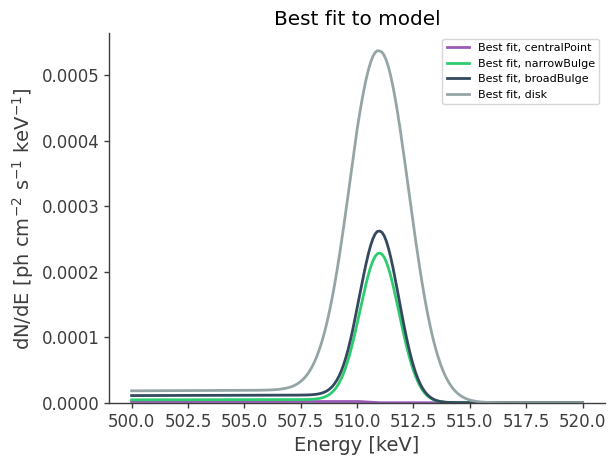

In [23]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
fluxes = {}

for model in models: 
    fluxes[model] = results.optimized_model[model].spectrum.main.shape(energy)

fig,ax = plt.subplots()
for model in models:
    ax.plot(energy, fluxes[model], label = f"Best fit, {model}",ls='-')
ax.set_ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
ax.set_xlabel("Energy [keV]", fontsize=14)
ax.set_title("Best fit to model")
ax.legend()
ax.set_ylim(0,);